<a href="https://colab.research.google.com/github/brainmentorspvtltd/IGDTU_PyTorchTraining/blob/main/IG_DenoisingAE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
from keras.datasets import mnist

In [2]:
(x_train, _), (x_test, _) = mnist.load_data()

11490434/11490434 [==============================] - 0s 0us/step


In [3]:
x_train.shape

(60000, 28, 28)

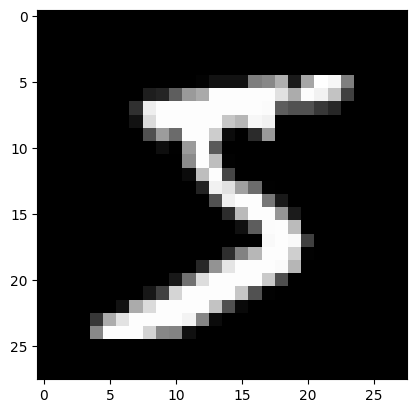

In [4]:
plt.imshow(x_train[0], cmap="gray")
plt.show()

In [5]:
x_train, x_test = x_train/255., x_test/255.

In [6]:
# x_train = np.reshape(x_train, (x_train.shape[0], 28,28,1))
# x_test = np.reshape(x_train, (x_test.shape[0], 28,28,1))

In [10]:
noise_threshold = 0.2
x_train_noisy = x_train + noise_threshold * np.random.normal(size=x_train.shape)
x_test_noisy = x_test + noise_threshold * np.random.normal(size=x_test.shape)

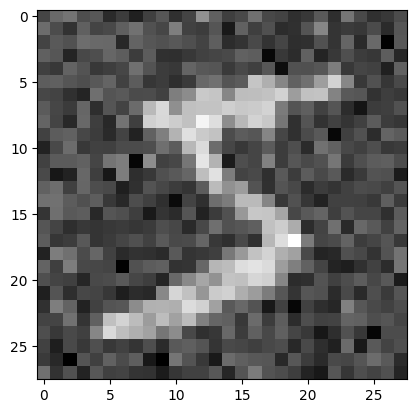

In [12]:
plt.imshow(x_train_noisy[0], cmap="gray")
plt.show()

In [13]:
x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)

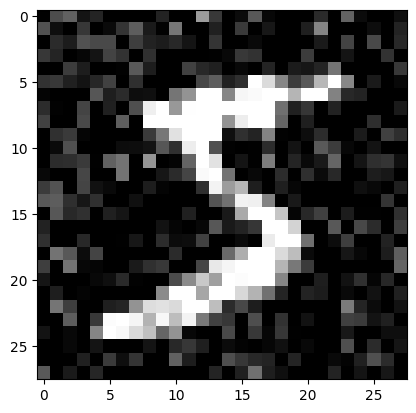

In [14]:
plt.imshow(x_train_noisy[0], cmap="gray")
plt.show()

In [182]:
class DenoisingAE(nn.Module):
  def __init__(self):
    super().__init__()
    # DownSampling
    self.encoder = nn.Sequential(
        nn.Conv2d(1, 32, (3,3), padding=1),
        nn.ReLU(),
        nn.MaxPool2d((2,2)),
        nn.Conv2d(32, 64, (3,3), padding=1),
        nn.ReLU(),
        nn.MaxPool2d((2,2)),
        nn.Conv2d(64, 128, (3,3), padding=1),
        nn.ReLU(),
        nn.MaxPool2d((2,2))
    )

    # UpSampling
    self.decoder = nn.Sequential(
        nn.ConvTranspose2d(128, 128, (3,3), stride=2, padding=0),
        nn.ReLU(),
        nn.ConvTranspose2d(128, 64, (2,2), stride=2, padding=0),
        nn.ReLU(),
        nn.ConvTranspose2d(64, 32, (2,2), stride=2, padding=0),
        nn.ReLU(),
        nn.ConvTranspose2d(32, 1, (1,1), stride=1, padding=0),
        nn.Sigmoid()
    )

  def forward(self, images):
    x = self.encoder(images)
    x = self.decoder(x)
    return x

In [183]:
model = DenoisingAE()

In [184]:
from torchsummary import summary

In [185]:
summary(model, input_size=(1,28,28),device="cpu")

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 28, 28]             320
              ReLU-2           [-1, 32, 28, 28]               0
         MaxPool2d-3           [-1, 32, 14, 14]               0
            Conv2d-4           [-1, 64, 14, 14]          18,496
              ReLU-5           [-1, 64, 14, 14]               0
         MaxPool2d-6             [-1, 64, 7, 7]               0
            Conv2d-7            [-1, 128, 7, 7]          73,856
              ReLU-8            [-1, 128, 7, 7]               0
         MaxPool2d-9            [-1, 128, 3, 3]               0
  ConvTranspose2d-10            [-1, 128, 7, 7]         147,584
             ReLU-11            [-1, 128, 7, 7]               0
  ConvTranspose2d-12           [-1, 64, 14, 14]          32,832
             ReLU-13           [-1, 64, 14, 14]               0
  ConvTranspose2d-14           [-1, 32,

In [186]:
type(x_train_noisy)

numpy.ndarray

In [194]:
x_train_data = torch.from_numpy(x_train_noisy).type(torch.float)
x_test_data = torch.from_numpy(x_test_noisy).type(torch.float)

In [195]:
x_train_data.shape

torch.Size([60000, 28, 28])

In [196]:
device = "cuda" if torch.cuda.is_available() else "cpu"
x_train_data = x_train_data.to(device)
x_test_data = x_test_data.to(device)

In [197]:
trainLoader = DataLoader(x_train_data, batch_size=32, shuffle=True)
testLoader = DataLoader(x_test_data, batch_size=32, shuffle=True)

In [198]:
model = DenoisingAE().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fn = nn.MSELoss()

train_loss = []
epochs = 20
for epoch in range(epochs):
  running_loss = 0.0
  for data in trainLoader:
    img = data
    img = img.to(device)
    optimizer.zero_grad()
    output = model(img)
    loss = loss_fn(output, img)
    loss.backward()
    optimizer.step()
    running_loss += loss.item()

  loss = running_loss / len(trainLoader)
  train_loss.append(loss)
  print("Train Loss :",loss)


RuntimeError: ignored